<a id='back_to_top'></a>
# PSI - Forecasting Validation


Index
1. [Boilerplate Snowflake Connection](#snowflake)
2. [Import Data](#import_data)
3. [My Spot](#my_spot)
4. [Expected Content](#expected_content)
5. [Monthly Aggregate](#monthly_aggregates)


## Boilerplate Snowflake Connection & Packages <a id='snowflake'></a>


In [1]:
%%time
%conda install -c conda-forge fbprophet

Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::seaborn-base==0.11.1=pyhd8ed1ab_1
  - conda-forge/noarch::nbclassic==0.2.6=pyhd8ed1ab_0
  - conda-forge/linux-64::blaze==0.11.3=py36_0
  - conda-forge/linux-64::matplotlib==3.3.4=py36h5fab9bb_0
  - defaults/linux-64::_anaconda_depends==5.1.0=py36_2
  - conda-forge/noarch::jupyterlab==3.0.9=pyhd8ed1ab_0
  - conda-forge/noarch::python-language-server==0.36.2=pyhd8ed1ab_0
  - conda-forge/noarch::jupyterlab_server==2.3.0=pyhd8ed1ab_0
  - conda-forge/noarch::pyls-black==0.4.6=pyh9f0ad1d_0
  - conda-forge/linux-64::scikit-image==0.16.2=py36hb3f55d8_0
  - conda-forge/noarch::black==20.8b1=py_1
  - conda-forge/linux-64::anyio==2.1.0=py36h5fab9bb_0
  - conda-forge/linux-64::jupyter_server==1.4.1=py36h5fab9bb_0
  - conda-forge/linux-64::bokeh==2.2.3=py36h5fab9bb_0
  - conda-forge/noarch::aiobotocore==1.2.1=pyhd8ed1ab_0
  -

In [25]:
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

In [19]:
pip install jupyternotify

  Created wheel for jupyternotify: filename=jupyternotify-0.1.15-py3-none-any.whl size=8721 sha256=1cf3993189728bc18281ea736ade8b2c5b99c91b24351c397a7b2c2c1b2f2eb4
  Stored in directory: /home/ec2-user/.cache/pip/wheels/68/5b/f0/bcb83c7c2bb680feb7f4de11f072a3106a0cb9e7752fff19fe
Successfully built jupyternotify
Note: you may need to restart the kernel to use updated packages.


In [2]:
from io import StringIO

import causal_lib as csl
import pandas as pd
import seaborn as sns
import numpy as np
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

## Limit Size of Returned Records
MAX_QUERY_RETURN_SIZE = 10000000

## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'
MAX_FETCHED_RESULTSET_SIZE = MAX_QUERY_RETURN_SIZE

%%bash
# # # # # # # # # 
# Libs config.
# # # # # # # # # 
CFFI_VERSION=$(python -m pip list 2>/dev/null | grep cffi | awk '{print $2}')
# echo "Current cffi version="$CFFI_VERSION

if [[ "$CFFI_VERSION" == "1.10.0" ]]
then
    echo "Uninstalling cffi"
    pip uninstall --yes cffi
fi

yum_log=$(sudo yum history new && sudo yum install -y libffi-devel openssl-devel)
pip_log=$(python -m pip install --upgrade pip snowflake-connector-python tabulate ipywidgets sqlparse textile)
yum_log=$(jupyter nbextension enable --py widgetsnbextension 2> /dev/null)

if [[ "$CFFI_VERSION" == "cffi (1.10.0)" ]]
then 
   echo "Configuration has changed; restart notebook"
fi

SyntaxError: invalid syntax (<ipython-input-2-358ba25a350d>, line 22)

In [33]:
import json
import snowflake.connector
from abc import ABCMeta, abstractmethod
import boto3

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
        

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx

MAX_FETCHED_RESULTSET_SIZE = MAX_QUERY_RETURN_SIZE

def execute_query(query: str):
    cur = ctx.cursor()
    try:
        cur.execute(query)
        while True:
            results = cur.fetchmany(MAX_FETCHED_RESULTSET_SIZE)
            if len(results) == 0:
                break
            for row in results:
                yield row
    finally:
        cur.close()
         
def execute_insert_query(query: str):
    cur = ctx.cursor()
    try:
        cur.execute(query)
    finally:
        cur.close()

def snowflake_data_pull(query,columns):
    # DB, schema, and table names
    DB_NAME = "max_dev"
    SCHEMA = "workspace"

    # Input data from max_dev snowflake
    connector = SnowflakeConnector(SSMPSCredentials(SF_CREDS))
    ctx = connector.connect(dbname=DB_NAME, schema=SCHEMA)
    df = pd.DataFrame(execute_query(query), columns=columns)
    return df

In [1]:
DB_NAME = "max_dev"
SCHEMA = "workspace"

# Input data from max_dev snowflake
connector = SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx = connector.connect(dbname=DB_NAME, schema=SCHEMA)

NameError: name 'SnowflakeConnector' is not defined

# Scale Data

<a id='scale_data'></a>

[Back to Top](#back_to_top)

In [1]:
# Return to previously pickled data subset
df = csl.import_pickle("psi_max_2021_04_07")

NameError: name 'csl' is not defined

In [62]:
# Combine Max and Now data into 1 dataset
df_max = df[(df['request_date']>='2020-06-01')].reset_index(drop=True)
df_max = df_max[['tier', 'request_date', 'tier_hours_per_sub', 'avail_asset_hours', 'avail_asset_count']]
df_max = df_max.rename(columns={'tier':'tier', 'request_date':'request_date', 'tier_hours_per_sub':'hps',
                                 'avail_asset_hours':'hours', 'avail_asset_count':'assets'})

df_now = csl.import_pickle("psi_now_2021_03_19")
df_now = df_now[['tier', 'request_date', 'tier_hours_per_sub', 'avail_asset_hours', 'avail_asset_count']]
df_now = df_now.rename(columns={'tier':'tier', 'request_date':'request_date', 'tier_hours_per_sub':'hps', 
                                'avail_asset_hours':'hours', 'avail_asset_count':'assets'})


df_merge = pd.concat([df_now,df_max], axis=0)

max_historical_dte = pd.to_datetime('2021-04-04')

In [63]:
# Scale combined dataset
dfnow_scale = pd.pivot_table(df_now, values=['hps', 'hours', 'assets'], 
                          index=['request_date'], columns='tier', aggfunc='mean', fill_value=None, 
                          margins=False, dropna=True, margins_name='All', )
dfnow_scale.columns = [col[1]+'_'+col[0] for col in dfnow_scale.columns.values]


dfmax_pivot = pd.pivot_table(df_max, values=['hps', 'hours', 'assets'], 
                          index=['request_date'], columns='tier', aggfunc='mean', fill_value=None, 
                          margins=False, dropna=True, margins_name='All', )
dfmax_pivot.columns = [col[1]+'_'+col[0] for col in dfmax_pivot.columns.values]
# dfmax_pivot = dfmax_pivot.reset_index(drop=False)

dfnow_scale['1_hps'] = dfnow_scale['1_hps']/3
dfnow_scale['2_hps'] = dfnow_scale['2_hps']/4
dfnow_scale['3_hps'] = dfnow_scale['3_hps']/3

df_allcombo = pd.concat([dfnow_scale, dfmax_pivot])
df_allcombo = df_allcombo.reset_index(drop=False)
df_allcombo.loc[(df_allcombo.request_date > '2020-05-20') & (df_allcombo.request_date < '2020-08-26'),'1_assets'] = np.linspace(73, 50, 96)
df_allcombo.loc[(df_allcombo.request_date > '2020-05-20') & (df_allcombo.request_date < '2020-08-26'),'1_hours'] = np.linspace(54, 39, 96)

df_allcombo.loc[(df_allcombo.request_date > '2020-05-20') & (df_allcombo.request_date < '2020-08-26'),'2_assets'] = np.linspace(74, 55, 96)
df_allcombo.loc[(df_allcombo.request_date > '2020-05-20') & (df_allcombo.request_date < '2020-08-26'),'2_hours'] = np.linspace(55, 47, 96)


df_allcombo.loc[(df_allcombo.request_date > '2020-05-20') & (df_allcombo.request_date < '2020-08-26'),'3_assets'] = np.linspace(50, 169, 96)
df_allcombo.loc[(df_allcombo.request_date > '2020-05-20') & (df_allcombo.request_date < '2020-08-26'),'3_hours'] = np.linspace(50, 102, 96)

# Modeling Tiers<a id='modeling_tiers'></a>
<a id='my_spot'></a>



[Back to Top](#back_to_top)

In [1]:
from fbprophet import Prophet
import itertools
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import causal_lib as csl
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from fbprophet.diagnostics import performance_metrics, cross_validation
from fbprophet.make_holidays import make_holidays_df
%matplotlib inline

max_historical_dte = pd.to_datetime('2021-05-01')

In [2]:
# df_allcombo = csl.import_pickle("psi_scaled_2021_04_04")
df_allcombo = csl.import_pickle("psi_scaled_2021_05_13")

d1_train = df_allcombo.copy().loc[df_allcombo['request_date'] < pd.to_datetime(max_historical_dte)]
d1_train = d1_train.rename(columns={'request_date':'ds', '1_hps':'y'}).drop_duplicates().reset_index(drop=True)

d2_train = df_allcombo.copy().loc[df_allcombo['request_date'] < pd.to_datetime(max_historical_dte)]
d2_train = d2_train.rename(columns={'request_date':'ds', '2_hps':'y'}).drop_duplicates().reset_index(drop=True)

d3_train = df_allcombo.copy().loc[df_allcombo['request_date'] < pd.to_datetime(max_historical_dte)]
d3_train = d3_train.rename(columns={'request_date':'ds', '3_hps':'y'}).drop_duplicates().reset_index(drop=True)

## Parameters by tier:
* Tier 1: Remove historical days with <4 tier 1 assets available, prior strength of tier 1 for assets and hours = 20
    * MAPE = ~1.77 (had to limit historical data to 300 days, timeframe had something to do with the relative MAPE
    
* Tier 2: Remove historical days with <4 tier 1 titles available - no prior strength

* Tier 3: No dates removed, prior_scale = 20

## Relevant Functions

In [3]:

import math

year_list = [2020, 2021, 2022, 2023, 2024]
country_name = 'US'
df_holiday = make_holidays_df(year_list, country_name)

df_holiday['upper_window'] = 7
df_holiday['lower_window'] = -3

def root_mean_square_error(y_actual, y_predicted):
    mse = np.square(np.subtract(y_actual,y_predicted)).mean() 
    rmse = math.sqrt(mse)
    return rmse

def prop_error(n, error, correction):
    cml_error = (np.sqrt(n)/n)*error*correction
    return cml_error
   
def daily_rsme(df_cv, h):    
    df_cv['h_day'] = df_cv.groupby(by='cutoff')['ds'].rank()
    df_horizon = df_cv.loc[df_cv.h_day==h].copy()

    date_range = pd.date_range(df_horizon.ds.min(), df_horizon.ds.max()).to_list()
    date_list = []
    rmse_list =[]
    for date in date_range:
        daily_rmse = root_mean_square_error(df_horizon.loc[(df_horizon.ds==date),'y'], df_horizon.loc[(df_horizon.ds==date),'yhat'])
        rmse_list.append(daily_rmse)
        date_list.append(date)

    df_temp = pd.DataFrame(data = {'rmse_daily':rmse_list,'ds':date_list}, columns =['ds','rmse_daily'])
    return df_temp

## Tier 1 - Train & Validate

In [4]:
# Train Model
m = Prophet(yearly_seasonality=True
                   , daily_seasonality=False
                   , seasonality_mode='multiplicative'
                   , changepoint_prior_scale=0.005
                   , holidays = df_holiday)

m.add_regressor('1_assets', prior_scale=20)
m.add_regressor('1_hours', prior_scale=20)

m.add_regressor('2_assets')
m.add_regressor('2_hours')

m.add_regressor('3_assets')
m.add_regressor('3_hours')

d1_train.loc[(d1_train['1_assets'] < 4),'y'] = None
m.fit(d1_train[1:])

future_yearly = m.make_future_dataframe(periods=2000)
future = df_allcombo.loc[df_allcombo['request_date'] >= future_yearly.ds.min()].loc[
df_allcombo['request_date'] <= future_yearly.ds.max()].rename(columns={'request_date':'ds'}).fillna(0)
forecast = m.predict(future)

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


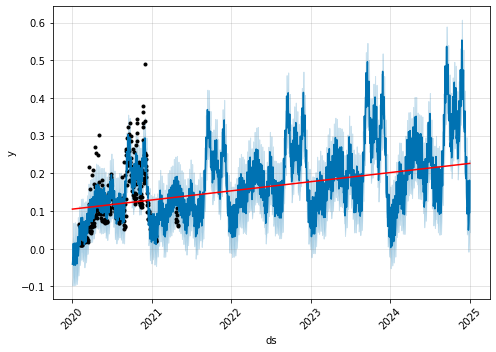

In [42]:
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
# fig1.gca().set_ylim([-0.2, 1])
# fig1.gca().set_xlim([pd.to_datetime('2020-01-01'), pd.to_datetime('2022-07-01')])
fig1.set_size_inches(7, 5)
plt.xticks(rotation=45)
plt.tight_layout()

INFO:fbprophet:Making 70 forecasts with cutoffs between 2020-10-28 00:00:00 and 2021-03-31 00:00:00


  0%|          | 0/70 [00:00<?, ?it/s]


Tier 1 Daily RMSE 30 Day
Avg: 0.17692
Median: 0.14664

1 Month Agg Error: 0.27456
CPU times: user 4min 9s, sys: 490 ms, total: 4min 10s
Wall time: 4min 9s


array([[<AxesSubplot:title={'center':'rmse_daily'}>]], dtype=object)

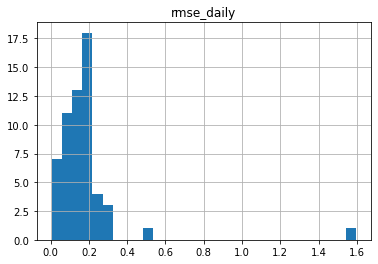

In [50]:
%%time 
#Data Through April - 300 initial; 30 days
df_cv = cross_validation(m, initial='270 days', horizon='30 days', period='1 days')

df_30 = daily_rsme(df_cv, 30)
print(f"\nTier 1 Daily RMSE 30 Day")
print(f"Avg: {df_30['rmse_daily'].mean():.5f}")
print(f"Median: {df_30['rmse_daily'].median():.5f}")
print(f"\n1 Month Agg Error: {prop_error(30, df_30['rmse_daily'].mean(), 8.5):.5f}")
df_30.hist(bins=30)

INFO:fbprophet:Making 40 forecasts with cutoffs between 2020-10-28 00:00:00 and 2021-03-01 00:00:00


  0%|          | 0/40 [00:00<?, ?it/s]


Tier 1 Daily RMSE 60 Day
Avg: 0.18579
Median: 0.18982

2 Month Agg Error: 0.28833

CPU times: user 12min, sys: 11min 58s, total: 23min 59s
Wall time: 3min 14s


array([[<AxesSubplot:title={'center':'rmse_daily'}>]], dtype=object)

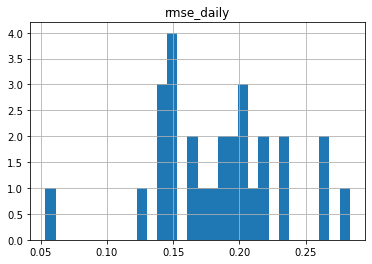

In [38]:
%%time 
#Data Through April - 280 initial; 60 days
df_cv = cross_validation(m, initial='270 days', horizon='60 days', period='1 days')

df_60 = daily_rsme(df_cv, 60)
print(f"\nTier 1 Daily RMSE 60 Day")
print(f"Avg: {df_60['rmse_daily'].mean():.5f}")
print(f"Median: {df_60['rmse_daily'].median():.5f}")
print(f"\n2 Month Agg Error: {prop_error(30, df_60['rmse_daily'].mean(), 8.5):.5f}\n")
df_60.hist(bins=30)

In [44]:
df_90.loc[df_90['ds']<='2021-01-22','rmse_daily'].mean()

0.18846694630422436

INFO:fbprophet:Making 115 forecasts with cutoffs between 2020-10-08 00:00:00 and 2021-01-30 00:00:00


  0%|          | 0/115 [00:00<?, ?it/s]


Tier 1 Daily RMSE 90 Day
Avg: 0.46910
Median: 0.18425

3 Month Agg Error: 0.72798

CPU times: user 26min 10s, sys: 24min 38s, total: 50min 49s
Wall time: 7min 59s


array([[<AxesSubplot:title={'center':'rmse_daily'}>]], dtype=object)

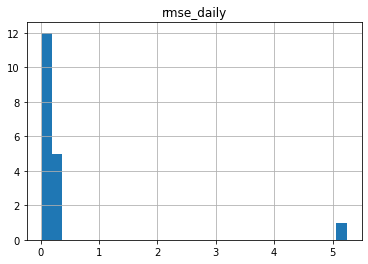

In [35]:
%%time 
#Data Through April - 200 initial; 90 days
df_cv = cross_validation(m, initial='220 days', horizon='90 days', period='1 days')

df_90 = daily_rsme(df_cv, 90)
print(f"\nTier 1 Daily RMSE 90 Day")
print(f"Avg: {df_90['rmse_daily'].mean():.5f}")
print(f"Median: {df_90['rmse_daily'].median():.5f}")
print(f"\n3 Month Agg Error(AVG): {prop_error(30, df_90['rmse_daily'].mean(), 8.5):.5f}")
print(f"\n3 Month Agg Error(Median): {prop_error(30, df_90['rmse_daily'].median(), 8.5):.5f}\n")

df_90.hist(bins=30)

INFO:fbprophet:Making 165 forecasts with cutoffs between 2020-08-19 00:00:00 and 2021-01-30 00:00:00


  0%|          | 0/165 [00:00<?, ?it/s]


Tier 1 Daily RMSE 90 Day
Avg: 0.53859
Median: 0.18533

3 Month Agg Error(AVG): 0.83584

3 Month Agg Error(Median): 0.28762

CPU times: user 1h 5min 54s, sys: 44min 54s, total: 1h 50min 48s
Wall time: 32min 17s


array([[<AxesSubplot:title={'center':'rmse_daily'}>]], dtype=object)

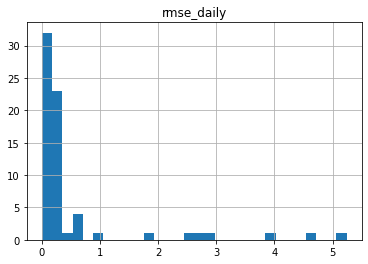

In [5]:
%%time 
#Data Through April - 200 initial; 90 days
df_cv = cross_validation(m, initial='200 days', horizon='90 days', period='1 days')

df_90 = daily_rsme(df_cv, 90)
print(f"\nTier 1 Daily RMSE 90 Day")
print(f"Avg: {df_90['rmse_daily'].mean():.5f}")
print(f"Median: {df_90['rmse_daily'].median():.5f}")
print(f"\n3 Month Agg Error(AVG): {prop_error(30, df_90['rmse_daily'].mean(), 8.5):.5f}")
print(f"\n3 Month Agg Error(Median): {prop_error(30, df_90['rmse_daily'].median(), 8.5):.5f}\n")

df_90.hist(bins=30)

In [6]:
%%time 
df_cv = cross_validation(m, initial='190 days', horizon='120 days', period='1 days')

df_90 = daily_rsme(df_cv, 120)
print(f"\nTier 1 Daily RMSE 120 Day")
print(f"Avg: {df_120['rmse_daily'].mean():.5f}")
print(f"Median: {df_120['rmse_daily'].median():.5f}")
print(f"\n3 Month Agg Error(AVG): {prop_error(30, df_120['rmse_daily'].mean(), 8.5):.5f}")
print(f"\n3 Month Agg Error(Median): {prop_error(30, df_120['rmse_daily'].median(), 8.5):.5f}\n")

df_120.hist(bins=30)

INFO:fbprophet:Making 145 forecasts with cutoffs between 2020-08-09 00:00:00 and 2020-12-31 00:00:00


  0%|          | 0/145 [00:00<?, ?it/s]


Tier 1 Daily RMSE 120 Day


NameError: name 'df_120' is not defined

In [40]:
print(f"\n3 Month Agg Error(Median): {prop_error(30, df_90['rmse_daily'].median(), 8.5):.5f}\n")



3 Month Agg Error(Median): 0.28593



## Tier 2

In [10]:
d2_train = df_allcombo.copy().loc[df_allcombo['request_date'] < pd.to_datetime(max_historical_dte)]
d2_train = d2_train.rename(columns={'request_date':'ds', '2_hps':'y'}).drop_duplicates().reset_index(drop=True)

In [53]:
# Fit model for Tier 2
m2 = Prophet(yearly_seasonality=True, daily_seasonality=False
             , seasonality_mode='multiplicative'
             , changepoint_prior_scale=0.005, holidays = df_holiday)

m2.add_regressor('1_assets')
m2.add_regressor('1_hours')

m2.add_regressor('2_assets')
m2.add_regressor('2_hours')

m2.add_regressor('3_assets')
m2.add_regressor('3_hours')

# d2_train.loc[(d2_train['2_assets'] < 2),'y'] = None
m2.fit(d2_train[1:])

future_yearly = m2.make_future_dataframe(periods=2000)
future = df_allcombo.loc[df_allcombo['request_date'] >= future_yearly.ds.min()].loc[
df_allcombo['request_date'] <= future_yearly.ds.max()].rename(columns={'request_date':'ds'}).fillna(0)
forecast = m2.predict(future)

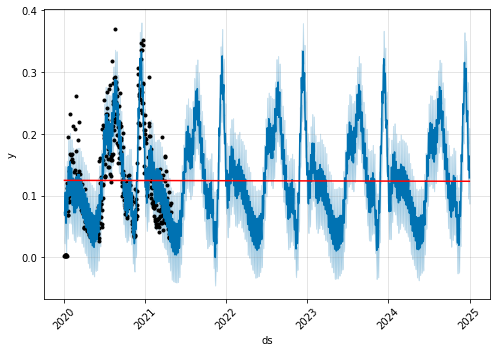

In [54]:
fig1 = m2.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m2, forecast)
# fig1.gca().set_ylim([-0.2, 1])
# fig1.gca().set_xlim([pd.to_datetime('2020-01-01'), pd.to_datetime('2022-07-01')])
fig1.set_size_inches(7, 5)
plt.xticks(rotation=45)
plt.tight_layout()

Using 200 Day Initial 

* Tier 2 Daily RMSE 30 Day
Avg: 0.41446
Median: 0.22402
* Tier 2 Daily RMSE 60 Day
Avg: 0.56022
Median: 0.34237
* Tier 2 Daily RMSE 120 Day
Avg: 0.79557
Median: 0.27292
* Tier 2 Daily RMSE 150 Day
Avg: 1.46463
Median: 0.32354

Using 260 initial - 60 day horizon
* Tier 2 Daily RMSE 30 Day
Avg: 0.11907
Median: 0.11849
* Tier 2 Daily RMSE 60 Day
Avg: 0.05332
Median: 0.04059

INFO:fbprophet:Making 155 forecasts with cutoffs between 2020-10-28 00:00:00 and 2021-03-31 00:00:00


  0%|          | 0/155 [00:00<?, ?it/s]

Tier 2 Daily RMSE 30 Day
Avg: 0.12506
Median: 0.11055

1 Month Agg Error: 0.19408


array([[<AxesSubplot:title={'center':'rmse_daily'}>]], dtype=object)

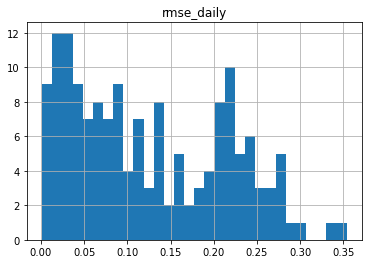

In [21]:
df_cv = cross_validation(m2, initial='360 days', horizon='30 days', period='1 days')
df_30 = daily_rsme(df_cv, 30)
print(f"\nTier 2 Daily RMSE 30 Day")
print(f"Avg: {df_30['rmse_daily'].mean():.5f}")
print(f"Median: {df_30['rmse_daily'].median():.5f}")
print(f"\n1 Month Agg Error: {prop_error(30, df_30['rmse_daily'].mean(), 8.5):.5f}\n")

df_30.hist(bins=30)


INFO:fbprophet:Making 125 forecasts with cutoffs between 2020-10-28 00:00:00 and 2021-03-01 00:00:00


  0%|          | 0/125 [00:00<?, ?it/s]

Tier 2 Daily RMSE 30 Day
Avg: 0.14467
Median: 0.13943

Tier 2 Daily RMSE 60 Day
Avg: 0.15806
Median: 0.11588

2 Month Agg Error: 0.24818


array([[<AxesSubplot:title={'center':'rmse_daily'}>]], dtype=object)

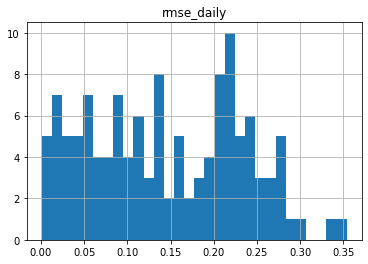

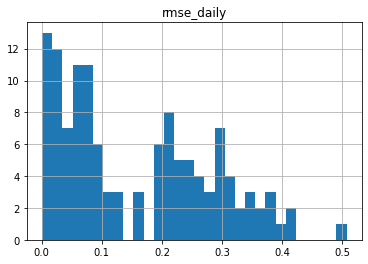

In [55]:
df_cv = cross_validation(m2, initial='300 days', horizon='60 days', period='1 days')

df_60 = daily_rsme(df_cv, 60)
print(f"\nTier 2 Daily RMSE 60 Day")
print(f"Avg: {df_60['rmse_daily'].mean():.5f}")
print(f"Median: {df_60['rmse_daily'].median():.5f}")

print(f"\n2 Month Agg Error: {prop_error(30, df_60['rmse_daily'].mean(), 8.6):.5f}\n")

df_60.hist(bins=30)

INFO:fbprophet:Making 95 forecasts with cutoffs between 2020-11-27 00:00:00 and 2021-03-01 00:00:00


  0%|          | 0/95 [00:00<?, ?it/s]


Tier 2 Daily RMSE 60 Day
Avg: 0.18452
Median: 0.20882

2 Month Agg Error: 0.28972



array([[<AxesSubplot:title={'center':'rmse_daily'}>]], dtype=object)

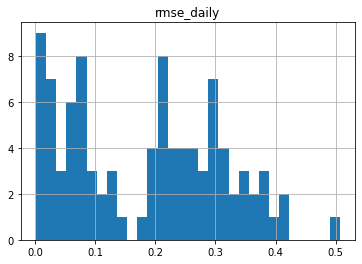

In [65]:
df_cv = cross_validation(m2, initial='330 days', horizon='60 days', period='1 days')

df_60 = daily_rsme(df_cv, 60)
print(f"\nTier 2 Daily RMSE 60 Day")
print(f"Avg: {df_60['rmse_daily'].mean():.5f}")
print(f"Median: {df_60['rmse_daily'].median():.5f}")

print(f"\n2 Month Agg Error: {prop_error(30, df_60['rmse_daily'].mean(), 8.6):.5f}\n")

df_60.hist(bins=30)

INFO:fbprophet:Making 125 forecasts with cutoffs between 2020-09-28 00:00:00 and 2021-01-30 00:00:00


  0%|          | 0/125 [00:00<?, ?it/s]


Tier 2 Daily RMSE 90 Day
Avg: 0.16346
Median: 0.16350

3 Month Agg Error: 0.25665

CPU times: user 46min 24s, sys: 53min 16s, total: 1h 39min 41s
Wall time: 7min 12s


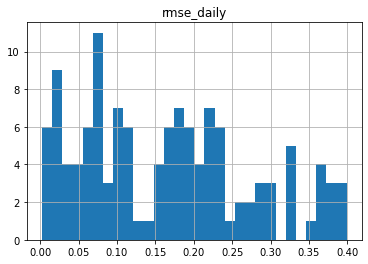

In [68]:
%%time
df_cv = cross_validation(m2, initial='270 days', horizon='90 days', period='1 days')

df_90 = daily_rsme(df_cv, 90)
print(f"\nTier 2 Daily RMSE 90 Day")
print(f"Avg: {df_90['rmse_daily'].mean():.5f}")
print(f"Median: {df_90['rmse_daily'].median():.5f}")
df_90.hist(bins=30)

print(f"\n3 Month Agg Error: {prop_error(30, df_90['rmse_daily'].mean(), 8.6):.5f}\n")

INFO:fbprophet:Making 165 forecasts with cutoffs between 2020-08-19 00:00:00 and 2021-01-30 00:00:00


  0%|          | 0/165 [00:00<?, ?it/s]


Tier 2 Daily RMSE 90 Day
Avg: 0.17621
Median: 0.16894

3 Month Agg Error: 0.27667

CPU times: user 1h 2min 18s, sys: 1h 11min 14s, total: 2h 13min 32s
Wall time: 9min 37s


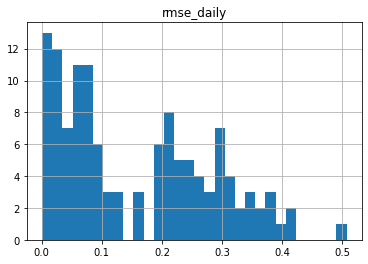

In [56]:
%%time
df_cv = cross_validation(m2, initial='230 days', horizon='90 days', period='1 days')

df_90 = daily_rsme(df_cv, 90)
print(f"\nTier 2 Daily RMSE 90 Day")
print(f"Avg: {df_90['rmse_daily'].mean():.5f}")
print(f"Median: {df_90['rmse_daily'].median():.5f}")
df_90.hist(bins=30)

print(f"\n3 Month Agg Error: {prop_error(30, df_90['rmse_daily'].mean(), 8.6):.5f}\n")

INFO:fbprophet:Making 165 forecasts with cutoffs between 2020-07-20 00:00:00 and 2020-12-31 00:00:00


  0%|          | 0/165 [00:00<?, ?it/s]


Tier 2 Daily RMSE 120 Day
Avg: 2.00366
Median: 0.19024

3 Month Agg Error: 3.14602

CPU times: user 1h 9min 58s, sys: 1h 12min 30s, total: 2h 22min 28s
Wall time: 16min 30s


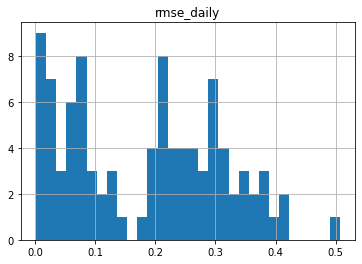

In [69]:
%%time
df_cv = cross_validation(m2, initial='200 days', horizon='120 days', period='1 days')

df_120 = daily_rsme(df_cv, 120)
print(f"\nTier 2 Daily RMSE 120 Day")
print(f"Avg: {df_120['rmse_daily'].mean():.5f}")
print(f"Median: {df_120['rmse_daily'].median():.5f}")
df_120.hist(bins=30)

print(f"\n4 Month Agg Error: {prop_error(30, df_120['rmse_daily'].mean(), 8.6):.5f}\n")

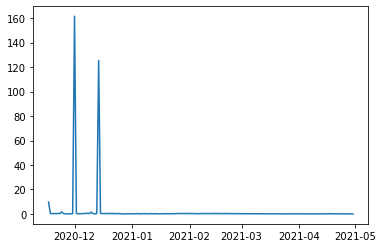

In [70]:
plt.plot(df_120['ds'], df_120['rmse_daily'])

In [87]:
clean_120 = df_120.loc[((df_120['ds']!='2020-11-17')&(df_120['ds']!='2020-12-01')&(df_120['ds']!='2020-12-14')), 'rmse_daily'].mean()

In [88]:
print(f"\n4 Month Agg Error: {prop_error(30, clean_120, 8.6):.5f}\n")


4 Month Agg Error: 0.32791



## Tier 3

In [4]:
m3 = Prophet(yearly_seasonality=True, daily_seasonality=False
             , seasonality_mode='multiplicative'
             , changepoint_prior_scale=0.005, holidays = df_holiday)

m3.add_regressor('1_assets')
m3.add_regressor('1_hours')

m3.add_regressor('2_assets')
m3.add_regressor('2_hours')

m3.add_regressor('3_assets', prior_scale=20)
m3.add_regressor('3_hours', prior_scale=20)

m3.fit(d3_train[1:])

future_yearly = m3.make_future_dataframe(periods=2000)
future = df_allcombo.loc[df_allcombo['request_date'] >= future_yearly.ds.min()].loc[
df_allcombo['request_date'] <= future_yearly.ds.max()].rename(columns={'request_date':'ds'}).fillna(0)
forecast = m3.predict(future)

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


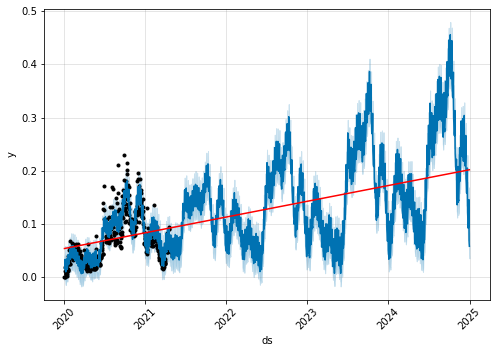

In [5]:
fig1 = m3.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m3, forecast)
# fig1.gca().set_ylim([-0.2, 1])
# fig1.gca().set_xlim([pd.to_datetime('2020-01-01'), pd.to_datetime('2022-07-01')])
fig1.set_size_inches(7, 5)
plt.xticks(rotation=45)
plt.tight_layout()

INFO:fbprophet:Making 95 forecasts with cutoffs between 2020-12-27 00:00:00 and 2021-03-31 00:00:00


  0%|          | 0/95 [00:00<?, ?it/s]

Tier 2 Daily RMSE 30 Day
Avg: 0.07299
Median: 0.07939

1 Month Agg Error: 0.11460


array([[<AxesSubplot:title={'center':'rmse_daily'}>]], dtype=object)

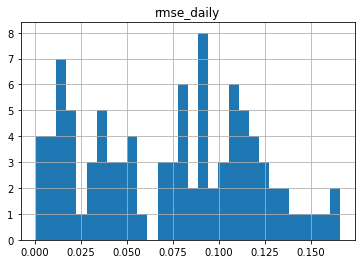

In [6]:
df_cv = cross_validation(m3, initial='360 days', horizon='30 days', period='1 days')
df_30 = daily_rsme(df_cv, 30)
print(f"Tier 2 Daily RMSE 30 Day")
print(f"Avg: {df_30['rmse_daily'].mean():.5f}")
print(f"Median: {df_30['rmse_daily'].median():.5f}")
print(f"\n1 Month Agg Error: {prop_error(30, df_30['rmse_daily'].mean(), 8.6):.5f}")

df_30.hist(bins=30)

INFO:fbprophet:Making 125 forecasts with cutoffs between 2020-10-28 00:00:00 and 2021-03-01 00:00:00


  0%|          | 0/125 [00:00<?, ?it/s]

Tier 2 Daily RMSE 30 Day
Avg: 0.08477
Median: 0.08431
Tier 2 Daily RMSE 60 Day
Avg: 0.10057
Median: 0.10607

2 Month Agg Error: 0.15608


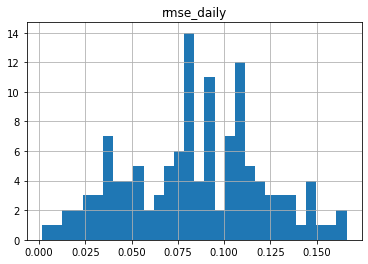

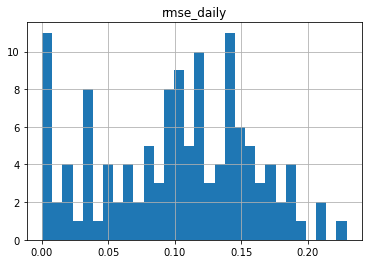

In [7]:
%%time
%%notify
df_cv = cross_validation(m3, initial='300 days', horizon='60 days', period='1 days')

df_60 = daily_rsme(df_cv, 60)
print(f"Tier 2 Daily RMSE 60 Day")
print(f"Avg: {df_60['rmse_daily'].mean():.5f}")
print(f"Median: {df_60['rmse_daily'].median():.5f}")
df_60.hist(bins=30)

print(f"\n2 Month Agg Error: {prop_error(30, df_60['rmse_daily'].mean(), 8.5):.5f}")


INFO:fbprophet:Making 95 forecasts with cutoffs between 2020-10-28 00:00:00 and 2021-01-30 00:00:00


  0%|          | 0/95 [00:00<?, ?it/s]

Tier 3 Daily RMSE 90 Day
Avg: 0.11922
Median: 0.12859

3 Month Agg Error: 0.18502

CPU times: user 35min 7s, sys: 40min 39s, total: 1h 15min 47s
Wall time: 5min 27s


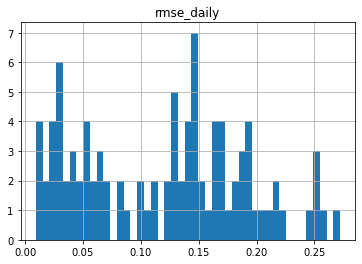

In [93]:
%%time
df_cv = cross_validation(m3, initial='300 days', horizon='90 days', period='1 days')

df_90 = daily_rsme(df_cv, 90)

print(f"Tier 3 Daily RMSE 90 Day")
print(f"Avg: {df_90['rmse_daily'].mean():.5f}")
print(f"Median: {df_90['rmse_daily'].median():.5f}")
df_90.hist(bins=45)

print(f"\n3 Month Agg Error: {prop_error(30, df_90['rmse_daily'].mean(), 8.5):.5f}\n")

In [ ]:
df_120

In [ ]:
%%time
df_cv = cross_validation(m3, initial='180 days', horizon='1 days', period='1 days')

df_120 = daily_rsme(df_cv, 120)
print(f"\nTier 3 Daily RMSE 120 Day")
print(f"Avg: {df_120['rmse_daily'].mean():.5f}")
print(f"Median: {df_120['rmse_daily'].median():.5f}")
df_120.hist(bins=30)

print(f"\nTier 3: 3 Month Agg Error: {prop_error(30, df_120['rmse_daily'].mean(), 8.5):.5f}\n")

INFO:fbprophet:Making 304 forecasts with cutoffs between 2020-06-30 00:00:00 and 2021-04-29 00:00:00


  0%|          | 0/304 [00:00<?, ?it/s]

## Combine Predictions

In [34]:
df_allcombo['pop_hps_hour'] = df_allcombo['pop_hps']/df_allcombo['pop_hours']
pop_train = df_allcombo.copy().loc[df_allcombo['request_date'] < pd.to_datetime(max_historical_dte)]
pop_train = pop_train[['request_date', 'pop_hps', 'pop_hps_hour']].copy().set_index('request_date')

fcast_pop = df_allcombo.copy()[df_allcombo['request_date']>=max_historical_dte][['request_date','pop_hours']].set_index('request_date')
fcast_pop['pop_yhat'] = fcast_pop['pop_hours']*pop_train['pop_hps_hour'].median()
df_fcast_pop = pd.concat([fcast_pop, pop_train]).sort_index()

In [43]:
# TIER 1 Save Forecasted Values
fcast_t1 = forecast.set_index('ds')['yhat']
actuals_t1 = df_allcombo.set_index('request_date')['1_hps']
actuals_t1.index.name = 'ds'

df_fcast_t1 = pd.DataFrame({'t1_hps':actuals_t1, 't1_yhat':fcast_t1})
df_fcast_t1['t1_pred'] = np.where(df_fcast_t1.index < pd.to_datetime(max_historical_dte), 
                                 df_fcast_t1['t1_hps'], df_fcast_t1['t1_yhat'])

In [46]:
# TIER 2 Save Forecasted Values
fcast_t2 = forecast.set_index('ds')['yhat']
actuals_t2 = df_allcombo.set_index('request_date')['2_hps']
actuals_t2.index.name = 'ds'

df_fcast_t2 = pd.DataFrame({'t2_hps':actuals_t2, 't2_yhat':fcast_t2})
df_fcast_t2['t2_pred'] = np.where(df_fcast_t2.index < pd.to_datetime(max_historical_dte), 
                                 df_fcast_t2['t2_hps'], df_fcast_t2['t2_yhat'])

In [50]:
# TIER 3 Save Forecasted Values
fcast_t3 = forecast.set_index('ds')['yhat']
actuals_t3 = df_allcombo.set_index('request_date')['3_hps']
actuals_t3.index.name = 'ds'

df_fcast_t3 = pd.DataFrame({'t3_hps':actuals_t3, 't3_yhat':fcast_t3})
df_fcast_t3['t3_pred'] = np.where(df_fcast_t3.index < pd.to_datetime(max_historical_dte), 
                                 df_fcast_t3['t3_hps'], df_fcast_t3['t3_yhat'])

In [51]:
predictions_all = df_fcast_t1.join(df_fcast_t2).join(df_fcast_t3).join(df_fcast_pop)
# csl.save_pickle(predictions_all, 'tier_predictions_2020_3_25')
csl.save_pickle(predictions_all, 'tier_predictions_2020_5_14')

Monthly Corrections - tier 1=8.5; tier 2=8.6; tier 3=8.5; pop=10.9


# Set up Dashboard Dataset


In [52]:
predictions_all = csl.import_pickle('tier_predictions_2020_5_14')
   
predictions_all = predictions_all.fillna(0)
predictions_all = predictions_all.reset_index(drop=False)
predictions_all['ds_month'] = predictions_all['ds'].apply(lambda x:x.replace(day=1))
predictions_all = predictions_all.groupby(by=['ds_month']).mean().reset_index().sort_values(by='ds_month')

predictions_all['t1_yhat'] = predictions_all['t1_yhat']*8.5
predictions_all['t1_hps'] = predictions_all['t1_hps']*8.5

predictions_all['t2_yhat'] = predictions_all['t2_yhat']*8.6
predictions_all['t2_hps'] = predictions_all['t2_hps']*8.6

predictions_all['t3_yhat'] = predictions_all['t3_yhat']*8.5
predictions_all['t3_hps'] = predictions_all['t3_hps']*8.5

predictions_all['pop_yhat'] = predictions_all['pop_yhat']*10.9
predictions_all['pop_hps'] = predictions_all['pop_hps']*10.9

predictions_all = predictions_all.set_index('ds_month')

pred_qtr = predictions_all.reset_index()

for col in ['t1_yhat', 't2_yhat', 't3_yhat','pop_yhat']:
    predictions_all[col] = np.where(predictions_all.index<max_historical_dte, .0, predictions_all[col])
for col in ['t1_hps', 't2_hps', 't3_hps', 'pop_hps']:
    predictions_all[col] = np.where(predictions_all.index>=max_historical_dte, .0, predictions_all[col])

In [58]:
df_output = predictions_all.copy()[['t1_yhat', 't1_hps', 't2_yhat', 't2_hps', 't3_yhat', 't3_hps', 'pop_yhat', 'pop_hps']]
df_output.columns = pd.MultiIndex.from_tuples([(col.split('_')[0], 'monthly_'+col.split('_')[1]) for col in df_output.columns], names=['tier', 'metric'])
df_output = df_output.stack(0).reset_index(drop=False)
df_output = df_output.rename(columns = {'ds_month':'period', 'monthly_hps':'psi_tier_actual_monthly', 'monthly_yhat':'psi_tier_prediction_monthly' })

In [56]:
# pred_qtr = csl.import_pickle('tier_predictions_2020_3_25')
pred_qtr = csl.import_pickle('tier_predictions_2020_5_14')  
pred_qtr = pred_qtr.fillna(0)
pred_qtr = pred_qtr.reset_index(drop=False)
pred_qtr['ds_qtr'] = pred_qtr['ds'].apply(lambda x: str(x.year)+' Q'+str(x.quarter))
# pred_qtr = pred_qtr.groupby(by=['ds_qtr']).mean().reset_index().sort_values(by='ds_qtr')

pred_qtr = pred_qtr.groupby(by=['ds_qtr']).agg({'ds':'min', 't1_yhat':'mean', 't1_hps':'mean', 't2_yhat':'mean', 't2_hps':'mean',
                                    't3_yhat':'mean', 't3_hps':'mean', 'pop_yhat':'mean', 'pop_hps':'mean'})

pred_qtr['t1_yhat'] = pred_qtr['t1_yhat']*17.6
pred_qtr['t1_hps'] = pred_qtr['t1_hps']*17.6

pred_qtr['t2_yhat'] = pred_qtr['t2_yhat']*18.5
pred_qtr['t2_hps'] = pred_qtr['t2_hps']*18.5

pred_qtr['t3_yhat'] = pred_qtr['t3_yhat']*17.8
pred_qtr['t3_hps'] = pred_qtr['t3_hps']*17.8

pred_qtr['pop_yhat'] = pred_qtr['pop_yhat']*23.2
pred_qtr['pop_hps'] = pred_qtr['pop_hps']*23.2

for col in ['t1_yhat', 't2_yhat', 't3_yhat','pop_yhat']:
    pred_qtr[col] = np.where(pred_qtr.index<'2021 Q2', .0, pred_qtr[col])
for col in ['t1_hps', 't2_hps', 't3_hps', 'pop_hps']:
    pred_qtr[col] = np.where(pred_qtr.index>='2021 Q2', .0, pred_qtr[col])

In [59]:
# Format and combine quarterly and monthly aggregates
pred_qtr = pred_qtr.reset_index(drop=False)

df_qtr_output = pred_qtr.copy()[['ds','t1_yhat', 't1_hps', 't2_yhat', 't2_hps', 't3_yhat', 't3_hps', 'pop_yhat', 'pop_hps']]
df_qtr_output = df_qtr_output.set_index('ds')
df_qtr_output.columns =  pd.MultiIndex.from_tuples([(col.split('_')[0], 'quarterly_'+col.split('_')[1]) for col in df_qtr_output.columns], names=['tier', 'metric'])
df_qtr_output = df_qtr_output.stack(0).reset_index(drop=False)
df_qtr_output = df_qtr_output.rename(columns = {'ds':'period', 'quarterly_hps':'psi_tier_actual_quarterly', 'quarterly_yhat':'psi_tier_prediction_quarterly' })

df_qtr_output = df_qtr_output.set_index(['period','tier'])
df_output = df_output.set_index(['period','tier'])
df_output = df_output.join(df_qtr_output,  how='left').reset_index(drop=False)
df_output = df_output[df_output['period']<='2024-12-31']
df_output.to_csv('psi_predictions_5_15.csv', index=False)

# Graph Findings

In [53]:
pred_qtr.loc[pred_qtr['ds'] >=pd.to_datetime('2022-01-01'),'pop_yhat'] = None

KeyError: 'ds'

In [54]:
predictions_all.loc[predictions_all.index >=pd.to_datetime('2022-01-01'),'pop_yhat'] = None

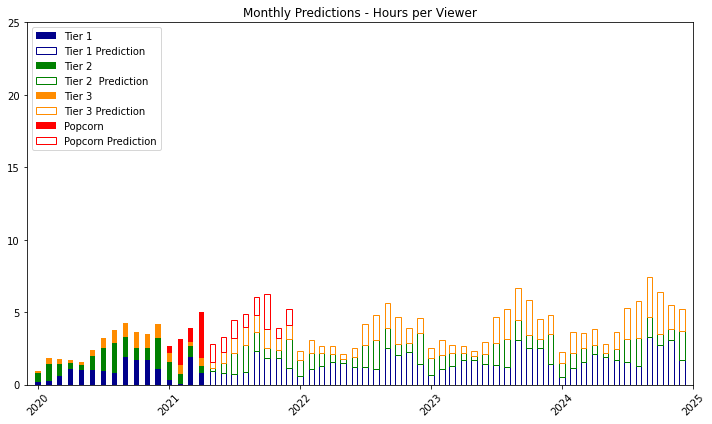

In [55]:
fig, ax = plt.subplots(figsize=(10,6))
fig.set_facecolor('white')

ax.bar(predictions_all.index, predictions_all['t1_hps'], label='Tier 1', width=15, edgecolor = 'none', color='darkblue' )
ax.bar(predictions_all.index, predictions_all['t1_yhat'], label='Tier 1 Prediction', width=15, edgecolor='darkblue', color='none')


ax.bar(predictions_all.index, predictions_all['t2_hps'], label='Tier 2', width=15, edgecolor = 'none', color='green',
       bottom=predictions_all['t1_hps'])
ax.bar(predictions_all.index, predictions_all['t2_yhat'], label='Tier 2  Prediction', width=15, edgecolor='green', color='none',
       bottom=predictions_all['t1_yhat'])


ax.bar(predictions_all.index, predictions_all['t3_hps'], label='Tier 3', width=15, edgecolor = 'none', color='darkorange',
       bottom=predictions_all['t1_hps']+predictions_all['t2_hps'])
ax.bar(predictions_all.index, predictions_all['t3_yhat'], label='Tier 3 Prediction', width=15, edgecolor='darkorange', color='none',
       bottom=predictions_all['t1_yhat']+predictions_all['t2_yhat'])


ax.bar(predictions_all.index, predictions_all['pop_hps'], label='Popcorn', width=15, edgecolor = 'none', color='red',
       bottom=predictions_all['t1_hps']+predictions_all['t2_hps']+predictions_all['t3_hps'])
ax.bar(predictions_all.index, predictions_all['pop_yhat'], label='Popcorn Prediction', width=15, edgecolor='red', color='none',
       bottom=predictions_all['t1_yhat']+predictions_all['t2_yhat']+predictions_all['t3_yhat'])


plt.xticks(rotation=45)
plt.title('Monthly Predictions - Hours per Viewer')
plt.ylim(0,25)
plt.xlim(pd.to_datetime('2019-12-01'), pd.to_datetime('2025-01-01'))
plt.legend(loc='upper left')
# plt.grid()
plt.tight_layout()

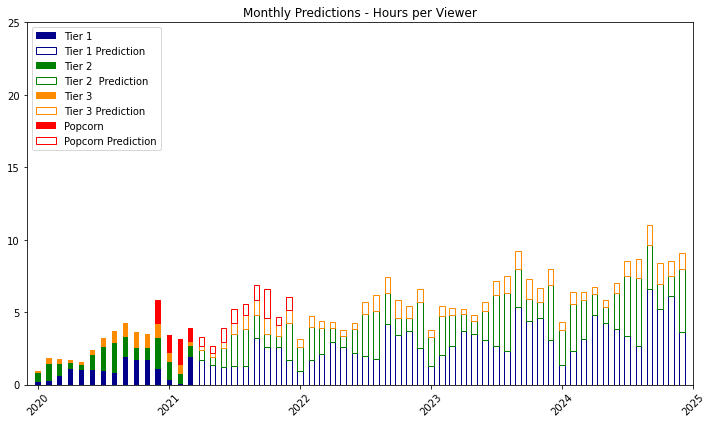

In [42]:
fig, ax = plt.subplots(figsize=(10,6))
fig.set_facecolor('white')

ax.bar(predictions_all.index, predictions_all['t1_hps'], label='Tier 1', width=15, edgecolor = 'none', color='darkblue' )
ax.bar(predictions_all.index, predictions_all['t1_yhat'], label='Tier 1 Prediction', width=15, edgecolor='darkblue', color='none')


ax.bar(predictions_all.index, predictions_all['t2_hps'], label='Tier 2', width=15, edgecolor = 'none', color='green',
       bottom=predictions_all['t1_hps'])
ax.bar(predictions_all.index, predictions_all['t2_yhat'], label='Tier 2  Prediction', width=15, edgecolor='green', color='none',
       bottom=predictions_all['t1_yhat'])


ax.bar(predictions_all.index, predictions_all['t3_hps'], label='Tier 3', width=15, edgecolor = 'none', color='darkorange',
       bottom=predictions_all['t1_hps']+predictions_all['t2_hps'])
ax.bar(predictions_all.index, predictions_all['t3_yhat'], label='Tier 3 Prediction', width=15, edgecolor='darkorange', color='none',
       bottom=predictions_all['t1_yhat']+predictions_all['t2_yhat'])


ax.bar(predictions_all.index, predictions_all['pop_hps'], label='Popcorn', width=15, edgecolor = 'none', color='red',
       bottom=predictions_all['t1_hps']+predictions_all['t2_hps']+predictions_all['t3_hps'])
ax.bar(predictions_all.index, predictions_all['pop_yhat'], label='Popcorn Prediction', width=15, edgecolor='red', color='none',
       bottom=predictions_all['t1_yhat']+predictions_all['t2_yhat']+predictions_all['t3_yhat'])


plt.xticks(rotation=45)
plt.title('Monthly Predictions - Hours per Viewer')
plt.ylim(0,25)
plt.xlim(pd.to_datetime('2019-12-01'), pd.to_datetime('2025-01-01'))
plt.legend(loc='upper left')
# plt.grid()
plt.tight_layout()

* Tier 1 - Month Agg Error: 0.27934
* Tier 2 - Month Agg Error Median: 0.20412
* Tier 3 - Quarterly Agg Error: 0.13579
*Tier 3 - Month Agg Error: 0.15519

In [148]:
# example data
x = np.append([0,0,0,0,0,0,0,0,0,0,0,0,0,0],np.arange(1, 1.92, 0.02))
# example error bar values that vary with x-position
error = 0.27934 * x
len(error)

60

In [5]:
df_slice = predictions_all[(predictions_all.index>=pd.to_datetime('2021-01-01'))&(predictions_all.index<=pd.to_datetime('2021-06-01'))].copy()

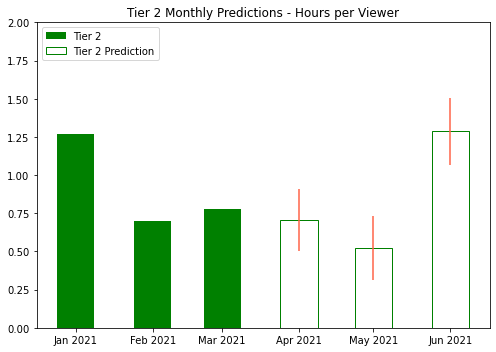

In [15]:
fig, ax = plt.subplots(figsize=(7,5), )
fig.set_facecolor('white')

# error =  np.where(df_slice['t3_yhat']==0,0, 0.15519)
#######
error2 = [0,0,0,0,0.18605,0.26497,0.42853, 0.50800]
ax.bar(df_slice.index, df_slice['t2_hps'], label='Tier 2', width=15,
       edgecolor = 'none', color='darkblue' )
ax.bar(df_slice.index, df_slice['t2_yhat'], label='Tier 2 Prediction', width=15, 
       yerr=error2, ecolor='tomato', edgecolor='darkblue', color='None',  )

#######
# error3 = [0,0,0,0.15519,0.175,0.2]
# ax.bar(df_slice.index, df_slice['t3_hps'], label='Tier 3', width=15,
#        edgecolor = 'none', color='darkblue' )
# ax.bar(df_slice.index, df_slice['t3_yhat'], label='Tier 3 Prediction', width=15, 
#        yerr=error3, ecolor='tomato', edgecolor='darkblue', color='None',  )


# ax.errorbar(df_slice.index, df_slice['t3_yhat'], yerr=error, barsabove=True)
plt.xticks(['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01'], 
           ['Jan 2021', 'Feb 2021', 'Mar 2021', 'Apr 2021', 'Month 1', 'Month 2', 'Month 3', 'Month 4']) 
#            rotation=45)
plt.title('Tier 2 Monthly Predictions - Hours per Viewer')
plt.ylim(0,3)
plt.legend(loc='upper left',prop={"size":10})
# plt.grid()
plt.tight_layout()

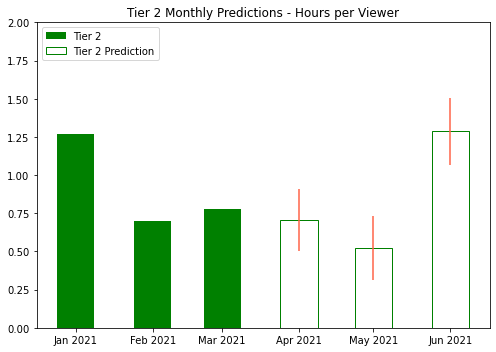

In [15]:
fig, ax = plt.subplots(figsize=(7,5), )
fig.set_facecolor('white')

# error =  np.where(df_slice['t3_yhat']==0,0, 0.15519)
#######
error2 = [0,0,0,0,0.18605,0.26497,0.42853, 0.50800]
ax.bar(df_slice.index, df_slice['t2_hps'], label='Tier 2', width=15,
       edgecolor = 'none', color='darkblue' )
ax.bar(df_slice.index, df_slice['t2_yhat'], label='Tier 2 Prediction', width=15, 
       yerr=error2, ecolor='tomato', edgecolor='darkblue', color='None',  )

#######
# error3 = [0,0,0,0.15519,0.175,0.2]
# ax.bar(df_slice.index, df_slice['t3_hps'], label='Tier 3', width=15,
#        edgecolor = 'none', color='darkblue' )
# ax.bar(df_slice.index, df_slice['t3_yhat'], label='Tier 3 Prediction', width=15, 
#        yerr=error3, ecolor='tomato', edgecolor='darkblue', color='None',  )


# ax.errorbar(df_slice.index, df_slice['t3_yhat'], yerr=error, barsabove=True)
plt.xticks(['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01'], 
           ['Jan 2021', 'Feb 2021', 'Mar 2021', 'Month 1', 'Month 2', 'Month 3', 'Month 4']) 
#            rotation=45)
plt.title('Tier 2 Monthly Predictions - Hours per Viewer')
plt.ylim(0,3)
plt.legend(loc='upper left',prop={"size":10})
# plt.grid()
plt.tight_layout()

In [45]:
pred_qtr.loc[pred_qtr['ds'] >=pd.to_datetime('2022-01-01'),'pop_yhat'] = None

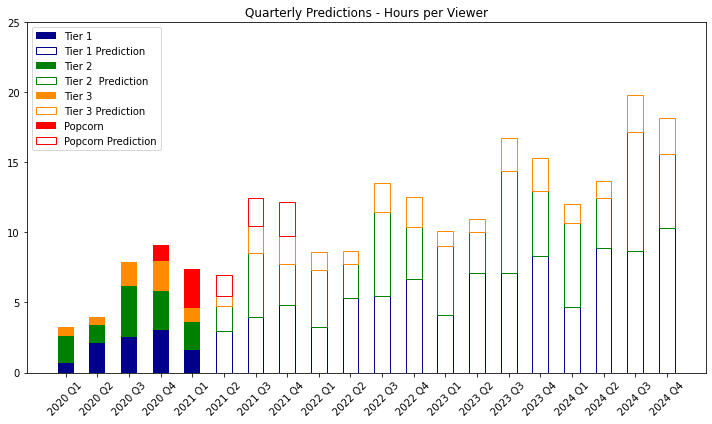

In [46]:
fig, ax = plt.subplots(figsize=(10,6))
# fig, ax = plt.subplots(figsize=(14,7))
fig.set_facecolor('white')

ax.bar(pred_qtr.index, pred_qtr['t1_hps'], label='Tier 1', width=.5, edgecolor = 'none', color='darkblue' )
ax.bar(pred_qtr.index, pred_qtr['t1_yhat'], label='Tier 1 Prediction', width=.5, edgecolor='darkblue', color='none')


ax.bar(pred_qtr.index, pred_qtr['t2_hps'], label='Tier 2', width=.5, edgecolor = 'none', color='green',
       bottom=pred_qtr['t1_hps'])
ax.bar(pred_qtr.index, pred_qtr['t2_yhat'], label='Tier 2  Prediction', width=.5, edgecolor='green', color='none',
       bottom=pred_qtr['t1_yhat'])


ax.bar(pred_qtr.index, pred_qtr['t3_hps'], label='Tier 3', width=.5, edgecolor = 'none', color='darkorange',
       bottom=pred_qtr['t1_hps']+pred_qtr['t2_hps'])
ax.bar(pred_qtr.index, pred_qtr['t3_yhat'], label='Tier 3 Prediction', width=.5, edgecolor='darkorange', color='none',
       bottom=pred_qtr['t1_yhat']+pred_qtr['t2_yhat'])


ax.bar(pred_qtr.index, pred_qtr['pop_hps'], label='Popcorn', width=.5, edgecolor = 'none', color='red',
       bottom=pred_qtr['t1_hps']+pred_qtr['t2_hps']+pred_qtr['t3_hps'])
ax.bar(pred_qtr.index, pred_qtr['pop_yhat'], label='Popcorn Prediction', width=.5, edgecolor='red', color='none',
       bottom=pred_qtr['t1_yhat']+pred_qtr['t2_yhat']+pred_qtr['t3_yhat'])


plt.xticks(rotation=45)
plt.title('Quarterly Predictions - Hours per Viewer')
plt.ylim(0,25)
# plt.xlim(-1, '2025 Q1')
plt.legend(loc='upper left')
# plt.grid()
plt.tight_layout()